In [1]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import json
nltk.download('punkt')
nltk.download('stopwords')
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import AdamW

[nltk_data] Downloading package punkt to
[nltk_data]     /home/nikita21546/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nikita21546/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/home/nikita21546/.local/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Step 2: Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=7)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [3]:
def load_json_file(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data


Train_data = load_json_file('train_file.json')
Val_data = load_json_file('val_file.json')
# x=6
Train_data = Train_data
Val_data = Val_data

l=(Train_data[0])

In [4]:
(l)

{'episode': 'utterance_3492',
 'speakers': ['Phoebe', 'Eric', 'Phoebe', 'Eric', 'Phoebe'],
 'emotions': ['surprise', 'fear', 'surprise', 'sadness', 'disgust'],
 'utterances': ['You-you\x85you had sex with Ursula?!',
  'Uh, a little bit. She-she-she walked in and I thought she was you and I kissed her and',
  "You didn't notice she was wearing different clothes?!",
  'Well I was just so excited to see you.',
  "Oh. Ew! Ew! Ew! Ugh! Y'know what? This is too weird."],
 'triggers': [1.0, 1.0, 0.0, 0.0, 0.0]}

In [5]:
train_X=[]
train_Y=[]
for i in Train_data:
    train_X.extend([j for j in i['utterances']])
    train_Y.extend([j for j in i['emotions']])
    
val_X=[]
val_Y=[]
for i in Val_data:
    val_X.extend([j for j in i['utterances']])
    val_Y.extend([j for j in i['emotions']])
    



In [6]:
ohe = { 'anger': [1, 0, 0, 0, 0, 0, 0], 'disgust': [0, 1, 0, 0, 0, 0, 0],'fear': [0, 0, 1, 0, 0, 0, 0],'joy': [0, 0, 0, 1, 0, 0, 0],'neutral': [0, 0, 0, 0, 1, 0, 0], 'sadness': [0, 0, 0, 0, 0, 1, 0],'surprise': [0, 0, 0, 0, 0, 0, 1]}
for i in range(len(train_Y)):
    k=train_Y[i]
    train_Y[i]=ohe[k]
    
for i in range(len(val_Y)):
    k=val_Y[i]
    val_Y[i]=ohe[k]

In [7]:


def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

train_X = [preprocess_text(sentence) for sentence in train_X]
val_X = [preprocess_text(sentence) for sentence in val_X]


In [8]:
train_X[0]
val_X[0]

'hey hold minute hold second think pearls nice'

In [9]:
#  clear cuda cache


In [27]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader
import torch
from sklearn.model_selection import train_test_split

# Define device (CPU or GPU)
# device = torch.device("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
learning_rate = 2e-5
epochs = 2

# Load BERT tokenizer (choose a pre-trained model for classification)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Function to preprocess data (tokenize and convert to tensors)
def preprocess_data(sentences, labels):
  tokenized_data = tokenizer(sentences, padding="max_length", truncation=True)
  input_ids = torch.tensor(tokenized_data['input_ids'], dtype=torch.long)
  attention_mask = torch.tensor(tokenized_data['attention_mask'], dtype=torch.long)
  labels = torch.tensor(labels, dtype=torch.long)
  return TensorDataset(input_ids, attention_mask, labels)

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_X, val_X, train_Y, val_Y

# Preprocess train and validation data
train_data = preprocess_data(X_train, y_train)
val_data = preprocess_data(X_val, y_val)

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

# Load pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(train_Y[0]))  # Adjust num_labels for your emotion set
model.to(device)

# Define optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss().float()

import torch

train_batch_losses, val_batch_losses = [], []
train_loss, val_loss = [], []

for epoch in range(epochs):
    torch.cuda.empty_cache()
    print(epoch)
    # Training phase
    model.train()
    epoch_train_loss = 0
    for batch_idx, batch in enumerate(train_loader):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Reset gradients to zero before starting backpropagation
        outputs = model(input_ids, attention_mask=attention_mask)
        labels = labels.float()
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        batch_loss = loss.item()
        epoch_train_loss += batch_loss
        train_batch_losses.append(batch_loss)  # Store batch loss
        torch.cuda.empty_cache()


    avg_train_loss = epoch_train_loss / len(train_loader)
    train_loss.append(avg_train_loss)  # Store average epoch training loss

    # Validation phase
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            labels=labels.float()
            val_batch_loss = criterion(outputs.logits, labels).item()
            epoch_val_loss += val_batch_loss
            val_batch_losses.append(val_batch_loss)  # Store batch loss
            torch.cuda.empty_cache()


    avg_val_loss = epoch_val_loss / len(val_loader)
    val_loss.append(avg_val_loss)  # Store average epoch validation loss
    
    # Print epoch information with average training and validation losses
    print(f"Epoch {epoch+1}/{epochs}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

print("Training complete!")

# # Import libraries for plotting (e.g., matplotlib)
# import matplotlib.pyplot as plt

# # Plot epoch vs train and validation loss
# plt.plot(range(epochs), train_loss, label='Train Loss')
# plt.plot(range(epochs), val_loss, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('BERT Model - Train vs. Validation Loss')
# plt.legend()
# plt.show()



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

0
Epoch 1/2: Train Loss: 0.6748, Val Loss: 0.2991
1
Epoch 2/2: Train Loss: 0.1887, Val Loss: 0.1324
Training complete!


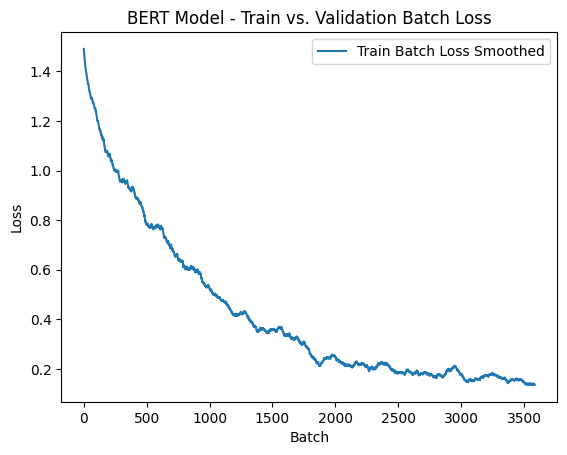

[0.26584500074386597, 0.1917508840560913, 0.0958935022354126, 0.13986240327358246, 0.15042470395565033, 0.3302778899669647, 0.12252116203308105, 0.05586030334234238, 0.27364808320999146, 0.40999555587768555, 0.1836748719215393, 0.5983574390411377, 0.22483128309249878, 0.1387442797422409, 0.17578136920928955, 0.10448557138442993, 0.21991032361984253, 0.2122308909893036, 0.14990930259227753, 0.1080533117055893, 0.5424730777740479, 0.3411943316459656, 0.3446286916732788, 0.3125171661376953, 0.3169524073600769, 0.28686094284057617, 0.3746187090873718, 0.09083444625139236, 0.5109784603118896, 0.12816327810287476, 0.4976755380630493, 0.4660998582839966, 0.27720487117767334, 0.4235019087791443, 0.39010003209114075, 0.4476783275604248, 0.3763572573661804, 0.4035146236419678, 0.25586071610450745, 0.26789820194244385, 0.4661916494369507, 0.1511601358652115, 0.3528846204280853, 0.4968964755535126, 0.278526246547699, 0.09480898827314377, 0.12327538430690765, 0.199085995554924, 0.22302493453025818,

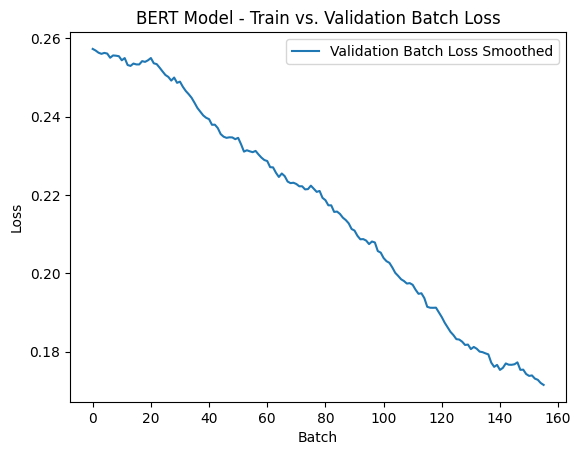

In [34]:
# graph batch losses

import matplotlib.pyplot as plt 

# plt.plot(range(len(train_batch_losses)), train_batch_losses, label='Train Batch Loss')
# plt.plot(range(len(val_batch_losses)), val_batch_losses, label='Validation Batch Loss')
# smoothing the curve
n=100
train_batch_losses_smoothed = [sum(train_batch_losses[i:i+n])/n for i in range(len(train_batch_losses)-n)]  
plt.plot(range(len(train_batch_losses_smoothed)), train_batch_losses_smoothed, label='Train Batch Loss Smoothed')



plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('BERT Model - Train vs. Validation Batch Loss')
plt.legend()
plt.show()


print(val_batch_losses)

#Do the same for validation batch losses
n=300
val_batch_losses_smoothed = [sum(val_batch_losses[i:i+n])/n for i in range(len(val_batch_losses)-n)]
print(val_batch_losses_smoothed)
plt.plot(range(len(val_batch_losses_smoothed)), val_batch_losses_smoothed, label='Validation Batch Loss Smoothed')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('BERT Model - Train vs. Validation Batch Loss')
plt.legend()
plt.show()




In [35]:
# # save the model file
# model.save_pretrained('model')
# tokenizer.save_pretrained('model')

#  save the model file using pickle
import pickle
with open('model_BERT.pkl', 'wb') as f:
    pickle.dump(model, f)


#load the model file using pickle
with open('model_BERT.pkl', 'rb') as f:
    model = pickle.load(f)

NameError: name 'train_batch_losses' is not defined

In [36]:
#give code to evaluate the model
# Evaluate the model
from sklearn.preprocessing import OneHotEncoder
import torch
import numpy as np
from tensorflow.keras.utils import to_categorical
# from torch.nn.functional import to_categorical

model.eval()
predictions = []
true_labels = []
ohe = { 'anger': [1, 0, 0, 0, 0, 0, 0], 'disgust': [0, 1, 0, 0, 0, 0, 0],'fear': [0, 0, 1, 0, 0, 0, 0],'joy': [0, 0, 0, 1, 0, 0, 0],'neutral': [0, 0, 0, 0, 1, 0, 0], 'sadness': [0, 0, 0, 0, 0, 1, 0],'surprise': [0, 0, 0, 0, 0, 0, 1]}    
eho = {0: [1, 0, 0, 0, 0, 0, 0], 1: [0, 1, 0, 0, 0, 0, 0], 2: [0, 0, 1, 0, 0, 0, 0], 3: [0, 0, 0, 1, 0, 0, 0], 4: [0, 0, 0, 0, 1, 0, 0], 5: [0, 0, 0, 0, 0, 1, 0], 6: [0, 0, 0, 0, 0, 0, 1]}
i=0
with torch.no_grad():
    for batch in val_loader:
        print(f"Batch {i} of {len(val_loader)}")
        i+=1
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        predictions.extend(torch.argmax(outputs.logits, axis=1).tolist())
        true_labels.extend(labels.tolist())


# Calculate accuracy


# correct = sum([1 if p == t else 0 for p, t in zip(predictions, true_labels)])
# print(correct)
# accuracy = correct / len(true_labels)
# print(f"Accuracy: {accuracy:.4f}")


Batch 0 of 228
Batch 1 of 228
Batch 2 of 228
Batch 3 of 228
Batch 4 of 228
Batch 5 of 228
Batch 6 of 228
Batch 7 of 228
Batch 8 of 228
Batch 9 of 228
Batch 10 of 228
Batch 11 of 228
Batch 12 of 228
Batch 13 of 228
Batch 14 of 228
Batch 15 of 228
Batch 16 of 228
Batch 17 of 228
Batch 18 of 228
Batch 19 of 228
Batch 20 of 228
Batch 21 of 228
Batch 22 of 228
Batch 23 of 228
Batch 24 of 228
Batch 25 of 228
Batch 26 of 228
Batch 27 of 228
Batch 28 of 228
Batch 29 of 228
Batch 30 of 228
Batch 31 of 228
Batch 32 of 228
Batch 33 of 228
Batch 34 of 228
Batch 35 of 228
Batch 36 of 228
Batch 37 of 228
Batch 38 of 228
Batch 39 of 228
Batch 40 of 228
Batch 41 of 228
Batch 42 of 228
Batch 43 of 228
Batch 44 of 228
Batch 45 of 228
Batch 46 of 228
Batch 47 of 228
Batch 48 of 228
Batch 49 of 228
Batch 50 of 228
Batch 51 of 228
Batch 52 of 228
Batch 53 of 228
Batch 54 of 228
Batch 55 of 228
Batch 56 of 228
Batch 57 of 228
Batch 58 of 228
Batch 59 of 228
Batch 60 of 228
Batch 61 of 228
Batch 62 of 228
Ba

In [37]:
eho[1]
t=[]
for i in predictions:
    t.append(eho[i])
predictions=t

In [ ]:
# print(predictions)
# print(true_labels)

In [38]:
correct = sum([1 if p == t else 0 for p, t in zip(predictions, true_labels)])
accuracy = correct / len(true_labels)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.9583


In [39]:
#give f1 score
from sklearn.metrics import f1_score
f1 = f1_score(true_labels, predictions, average='weighted')
print(f"F1 Score: {f1:.4f}")


F1 Score: 0.9584


In [40]:
# classification report
from sklearn.metrics import classification_report
target_names = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
print(classification_report(true_labels, predictions, target_names=target_names))


              precision    recall  f1-score   support

       anger       0.93      0.94      0.93       788
     disgust       0.98      0.94      0.96       215
        fear       0.99      0.93      0.96       265
         joy       0.94      0.97      0.95      1259
     neutral       0.98      0.97      0.98      3200
     sadness       0.97      0.92      0.94       558
    surprise       0.93      0.94      0.94      1008

   micro avg       0.96      0.96      0.96      7293
   macro avg       0.96      0.95      0.95      7293
weighted avg       0.96      0.96      0.96      7293
 samples avg       0.96      0.96      0.96      7293



In [41]:
print(predictions)
print (eho)
# flip eho dictionary
eho2 = {tuple(v): k for k, v in eho.items()}
print(eho2)
for i in range(len(predictions)):
    predictions[i] = eho2[tuple(predictions[i])]
    true_labels[i] = eho2[tuple(true_labels[i])]
    
print(predictions)
print(true_labels)



[[1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0, 0], [1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0, 0], [1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0, 0], [0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 1, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1], [0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 0, 0], [0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 

In [46]:

pred = predictions
true = true_labels

In [47]:
# print confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(true, pred)


array([[ 743,    1,    0,   22,    8,    1,   13],
       [   4,  202,    0,    3,    4,    1,    1],
       [   5,    2,  246,    1,    2,    2,    7],
       [  17,    1,    1, 1222,   14,    0,    4],
       [  11,    0,    1,   29, 3111,   11,   37],
       [  13,    1,    1,    7,   12,  513,   11],
       [   9,    0,    0,   19,   25,    3,  952]])